In [1]:
import importlib

import settings
import VPINN_tri_final
import mesh_lib

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights
import os 

importlib.reload(settings)
importlib.reload(mesh_lib)
importlib.reload(VPINN_tri_final)

from settings import *
from mesh_lib import *
from VPINN_tri_final import *
#tf.config.run_functions_eagerly(True)


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-11-17 12:00:47.807560: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 12:00:47.835724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 12:00:48.052784: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 12:00:48.054346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 12:00:48.794354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

settings_lib imported 
interpolator_lib imported
mesh_lib imported
settings_lib imported 
mesh_lib imported


degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


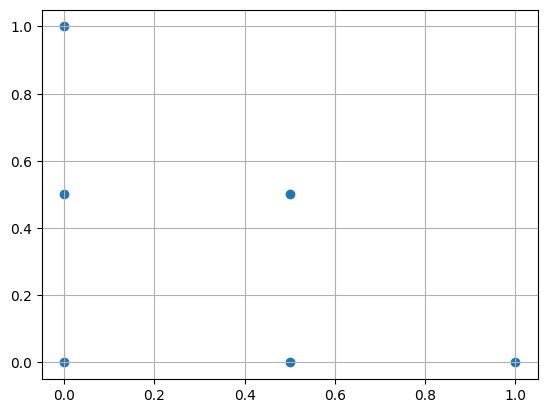

In [2]:
basis=interpolator(2,False,False,points=None)

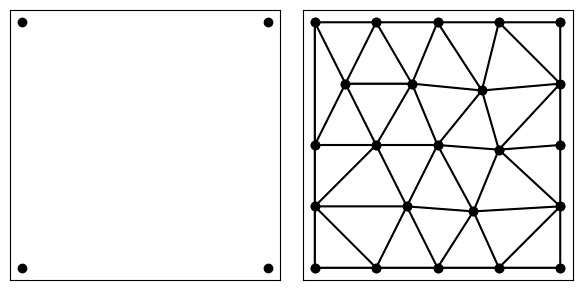

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr

# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A, 'qnea0.05')
tr.compare(plt,A,B)

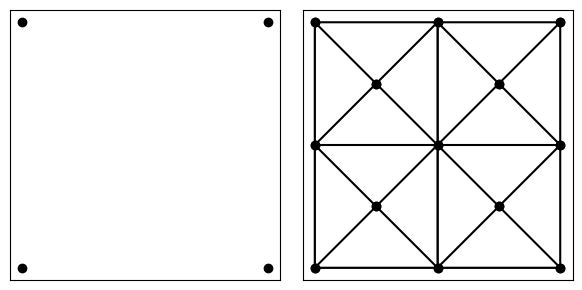

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr



# Step 1: Generate a fine mesh
A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
B = tr.triangulate(A,'qnea0.1')

tr.compare(plt, A, B)

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]


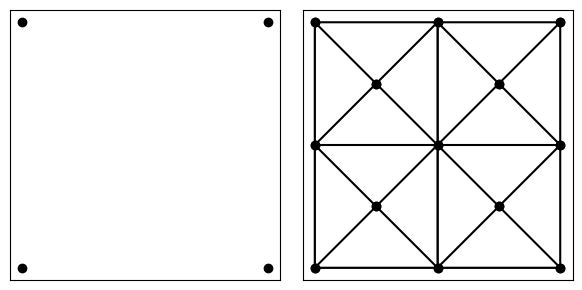

In [5]:

#edges flipping 

for i in range(len(B['edges'])):
    ii=B['edges'][i][0]
    jj=B['edges'][i][1]

    if ii>jj:
            B['edges'][i][0],B['edges'][i][1]=B['edges'][i][1],B['edges'][i][0]

tr.compare(plt, A, B)

print(B['edges'])

In [6]:

#util functions

def get_triangle_edges(triangle_vertices,edges):
    triangle_edges = []
 

    keep=np.zeros((3,),dtype=np.int64)

    for i in range(3):
        ii=triangle_vertices[i].copy()
        jj=triangle_vertices[(i + 1) % 3].copy()
        

        if(ii>jj):
            edge=np.array([jj,ii])
        else:
            edge=np.array([ii,jj])

        index= np.where(np.all(edges == edge, axis=1))[0][0]
        
        triangle_edges.append(index)

        if ii>jj:
            keep[i]=1

    triangle_edges=np.array(triangle_edges)
        
    return keep,triangle_edges

In [7]:
#flipping part + edges
l=[]
temp=[]
for triangle in B['triangles']:
    keep,t=get_triangle_edges(triangle,B['edges'])
    l.append(keep)
    temp.append(t)



keep=np.asarray(l)
edges_index_inside_triangle=np.asarray(temp)

In [8]:
B['keep']=keep
B['edges_index_inside_triangle']=edges_index_inside_triangle

In [9]:
B.keys()

dict_keys(['vertices', 'vertex_markers', 'triangles', 'neighbors', 'edges', 'edge_markers', 'keep', 'edges_index_inside_triangle'])

In [10]:
#exp
n_vertices=len(B['vertices'])
n_traingles=len(B['triangles'])
n_edges=len(B['edges'])

n_inside_edge=basis.n_inside_edge
n_inside=basis.n_inside

vertices_contribution=np.zeros((n_vertices,1))
edges_contribution=np.zeros((n_edges,n_inside_edge))
inside_contribution=np.zeros((n_traingles,n_inside))




for index,triangle in enumerate(B['triangles']):


    if (B['vertex_markers'][triangle[0]]==0):
            vertices_contribution[triangle[0]]=1
    else:
          vertices_contribution[triangle[0]]=2

    if (B['vertex_markers'][triangle[1]]==0):
            vertices_contribution[triangle[1]]=1
    else:
          vertices_contribution[triangle[1]]=2    

    if (B['vertex_markers'][triangle[2]]==0):
            vertices_contribution[triangle[2]]=1
    else:
          vertices_contribution[triangle[2]]=2
    

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][0]]==0):
           
           edges_contribution[B['edges_index_inside_triangle'][index][0]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][1]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][1]]+=3

    if(B['edge_markers'][B['edges_index_inside_triangle'][index][2]]==0):
           edges_contribution[B['edges_index_inside_triangle'][index][2]]+=3      



print(B['edges'])
print(edges_contribution)


    
                                   

[[ 4 12]
 [ 9 12]
 [ 4  9]
 [ 4  8]
 [ 4  5]
 [ 5  8]
 [ 7 10]
 [ 3  7]
 [ 3 10]
 [ 3  5]
 [ 5 10]
 [ 4  6]
 [ 6 12]
 [ 6  8]
 [ 0  6]
 [ 0  8]
 [ 2 11]
 [ 2  7]
 [ 7 11]
 [ 0  5]
 [ 2  9]
 [ 9 11]
 [ 4  7]
 [ 4 10]
 [ 4 11]
 [ 1  9]
 [ 1 12]
 [ 1  6]]
[[6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [0.]
 [6.]
 [0.]]


In [11]:
tfk=tf.keras
tfkl=tf.keras.layers

In [12]:
model = tfk.models.Sequential()
model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tfkl.Dense(10, activation='tanh',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))
model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer="glorot_uniform",dtype=tf.float64,bias_initializer="glorot_uniform"))

In [13]:
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371 (2.90 KB)
Trainable params: 371 (2.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
(None, 2)
(None, 1)


In [14]:
print(model.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64, numpy=
array([[-0.46390883, -0.17013227,  0.30703597, -0.54284454,  0.15447732,
         0.15832174,  0.3452734 , -0.47820502, -0.42330056, -0.29289512],
       [ 0.1540501 ,  0.15786753, -0.45133263,  0.30245726, -0.0414299 ,
        -0.67593148, -0.02407592,  0.19409929, -0.48595928,  0.28887865]])>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64, numpy=
array([ 0.14793283, -0.40648795, -0.41409636,  0.41973318, -0.50672523,
       -0.07308377,  0.44448681, -0.22753676,  0.24105152,  0.49864583])>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64, numpy=
array([[-0.17199977, -0.09028502, -0.29108656,  0.36760621, -0.07293933,
        -0.13345058, -0.04347911, -0.48021295,  0.4743776 , -0.27160693],
       [ 0.33232   , -0.35166343,  0.46250152,  0.11732734,  0.02827584,
        -0.23751403,  0.00373869, -0.37164098, -0.15007064, -0.23609377],
       [ 0.0403556 , -0.08091003, -0.14993831, -0.22206958,  0.2

In [15]:
from settings import *
N_tests = 2
N_elements = [5, 5]
params = {'scheme': 'VPINNs',
            'NN_struct': [2] + [5] * 3 + [1],
            'var_form': 1,
            'n_elements': tuple(N_elements),
            'n_test': [N_elements[0]*[N_tests], N_elements[1]*[N_tests]],
            'n_quad': 50,
            'n_bound': 80, # for every edge 
            'n_residual': 100,
            'domain': ((0.0, 1.0), (0.0, 1.0)),
            'Opt_Niter': 15000 + 1,
            'delta_test': 0.01,
            'N_test':N_tests}

25
degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


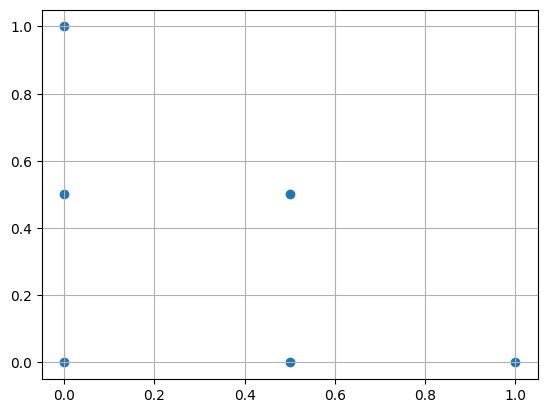

degree =  2  , local dof =  6  internal dof =  0  points inside each edge =  1
[[0 0]
 [1 0]
 [0 1]
 [1/2 0]
 [1/2 1/2]
 [0 1/2]]


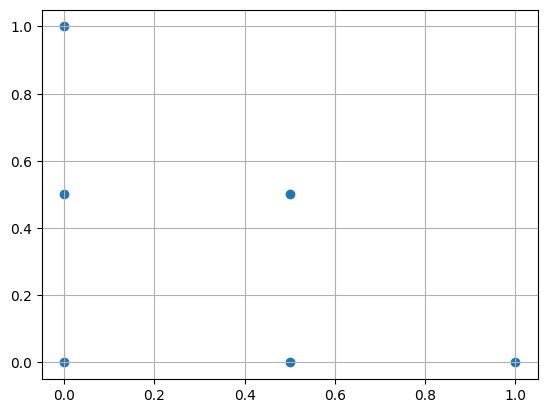

In [16]:
vp=VPINN(pb,params,B,model)

In [17]:
tf.reduce_mean(tf.square(model(vp.boundary_points) - vp.u_bound_exact))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6903893379081063>

In [18]:
_,c,J,B_D,B_DD=vp.b.change_of_coordinates(vp.mesh['vertices'][vp.mesh['triangles'][0]])

t=np.array(vp.grad_test)[0]

print((B_D@t))
print()
xy_quad_element=(B_D@ vp.grad_test)


print(xy_quad_element)

[[-5.01943047 -3.38357491 -1.09997987  0.95955137 -3.05385001 -1.87606661
  -0.23192371  1.25089772 -0.48931642  0.09081072  0.90064717  1.63102336
   1.47626404  1.59831901  1.76870333  1.92236972]
 [ 5.01943047  3.38357491  1.09997987 -0.95955137  3.05385001  1.87606661
   0.23192371 -1.25089772  0.48931642 -0.09081072 -0.90064717 -1.63102336
  -1.47626404 -1.59831901 -1.76870333 -1.92236972]]

tf.Tensor(
[[[ -5.01943047  -3.38357491  -1.09997987   0.95955137  -3.05385001
    -1.87606661  -0.23192371   1.25089772  -0.48931642   0.09081072
     0.90064717   1.63102336   1.47626404   1.59831901   1.76870333
     1.92236972]
  [  5.01943047   3.38357491   1.09997987  -0.95955137   3.05385001
     1.87606661   0.23192371  -1.25089772   0.48931642  -0.09081072
    -0.90064717  -1.63102336  -1.47626404  -1.59831901  -1.76870333
    -1.92236972]]

 [[  0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.     

In [19]:
print(vp.xy_quad_total)

tf.Tensor(
[[[0.54700955 0.48572395]
  [0.59431582 0.43078925]
  [0.66035365 0.35410239]
  [0.71991193 0.28493997]
  [0.66985833 0.48572395]
  [0.68853508 0.43078925]
  [0.71460716 0.35410239]
  [0.73812107 0.28493997]
  [0.83014167 0.48572395]
  [0.81146492 0.43078925]
  [0.78539284 0.35410239]
  [0.76187893 0.28493997]
  [0.95299045 0.48572395]
  [0.90568418 0.43078925]
  [0.83964635 0.35410239]
  [0.78008807 0.28493997]]

 [[0.2479093  0.2806428 ]
  [0.30665822 0.33176328]
  [0.38866959 0.40312563]
  [0.46263409 0.46748598]
  [0.18648491 0.34206719]
  [0.25954859 0.37887292]
  [0.36154283 0.43025238]
  [0.45352951 0.47659055]
  [0.10634324 0.42220886]
  [0.19808367 0.44033784]
  [0.32614999 0.46564522]
  [0.44165059 0.48846948]
  [0.04491885 0.48363325]
  [0.15097404 0.48744747]
  [0.29902324 0.49277198]
  [0.43254601 0.49757405]]

 [[0.2479093  0.7806428 ]
  [0.30665822 0.83176328]
  [0.38866959 0.90312563]
  [0.46263409 0.96748598]
  [0.18648491 0.84206719]
  [0.25954859 0.8788729

In [20]:
n_triangles=vp.n_triangles
xy_quad_total =vp.xy_quad_total

print(n_triangles)


x_eval=tf.reshape(vp.xy_quad_total,(-1,2))
grad=vp.eval_grad_NN(x_eval)

print(grad)

grad=tf.reshape(grad,(n_triangles,-1,2))

print(tf.shape(grad))

16
tf.Tensor(
[[0.29546932 0.21661529]
 [0.30038419 0.21843605]
 [0.30672728 0.2184921 ]
 [0.31166465 0.21607619]
 [0.28405599 0.19663893]
 [0.29111897 0.2029442 ]
 [0.30092668 0.20955356]
 [0.30955631 0.21311815]
 [0.2649728  0.17040695]
 [0.27638878 0.18263408]
 [0.29239789 0.1978658 ]
 [0.30668863 0.20925715]
 [0.247836   0.15088331]
 [0.26340264 0.16733109]
 [0.28519035 0.18895615]
 [0.3044037  0.2062993 ]
 [0.33481081 0.28596288]
 [0.32894231 0.27473635]
 [0.31743954 0.25475605]
 [0.30423506 0.23323888]
 [0.3257912  0.28879189]
 [0.32265073 0.27586156]
 [0.31434186 0.25465843]
 [0.30335827 0.23301645]
 [0.31380248 0.28843536]
 [0.31425923 0.27509549]
 [0.31021993 0.25386743]
 [0.30220381 0.23266007]
 [0.30457643 0.28529017]
 [0.3077527  0.27289605]
 [0.30701282 0.25276993]
 [0.30131149 0.23233678]
 [0.26920417 0.19205545]
 [0.25987521 0.17078526]
 [0.24562193 0.14144352]
 [0.23204051 0.11599576]
 [0.2632586  0.18362648]
 [0.25593381 0.16452843]
 [0.24385285 0.13806931]
 [0.2315949

In [21]:
grad_elem=tf.transpose(grad[0])
print(grad_elem)

print(grad_elem @vp.w_quad)

tf.Tensor(
[[0.29546932 0.30038419 0.30672728 0.31166465 0.28405599 0.29111897
  0.30092668 0.30955631 0.2649728  0.27638878 0.29239789 0.30668863
  0.247836   0.26340264 0.28519035 0.3044037 ]
 [0.21661529 0.21843605 0.2184921  0.21607619 0.19663893 0.2029442
  0.20955356 0.21311815 0.17040695 0.18263408 0.1978658  0.20925715
  0.15088331 0.16733109 0.18895615 0.2062993 ]], shape=(2, 16), dtype=float64)
tf.Tensor(
[[0.28552317]
 [0.19429726]], shape=(2, 1), dtype=float64)


In [22]:

w_quad = tf.concat([vp.w_quad.T, tf.ones_like(vp.w_quad.T)], axis=0)
print(w_quad)


tf.Tensor(
[[0.04713674 0.07077614 0.0451681  0.01084645 0.08837018 0.13268843
  0.08467945 0.02033452 0.08837018 0.13268843 0.08467945 0.02033452
  0.04713674 0.07077614 0.0451681  0.01084645]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]], shape=(2, 16), dtype=float64)


In [23]:
vp.grad_test

<tf.Tensor: shape=(6, 2, 16), dtype=float64, numpy=
array([[[-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486],
        [-2.50971524, -1.69178745, -0.54998993,  0.47977568,
         -1.52692501, -0.93803331, -0.11596185,  0.62544886,
         -0.24465821,  0.04540536,  0.45032358,  0.81551168,
          0.73813202,  0.79915951,  0.88435166,  0.96118486]],

       [[-0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054,
         -0.77158322,  0.10737205,  1.33436173,  2.44096054],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.   

In [24]:
vp.variational_loss()



(<tf.Tensor: shape=(13, 1), dtype=float64, numpy=
 array([[-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 2.52905854e-05],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 4.79831741e-01],
        [-0.00000000e+00],
        [-4.79861527e-01],
        [-3.21822505e-01],
        [ 3.21825933e-01]])>,
 <tf.Tensor: shape=(28, 1), dtype=float64, numpy=
 array([[ 1.98576243e+00],
        [ 1.98552141e+00],
        [ 2.28600487e-07],
        [ 2.75298903e+00],
        [ 2.22044605e-16],
        [ 4.47290951e+00],
        [-2.75294757e+00],
        [-0.00000000e+00],
        [-4.47290951e+00],
        [-0.00000000e+00],
        [-4.46689186e+00],
        [ 2.78867744e+00],
        [ 1.98578880e+00],
        [ 2.75298903e+00],
        [-0.00000000e+00],
        [ 4.46689186e+00],
        [-1.98552539e+00],
        [-0.00000000e+00],
        [-1.98578880e+00],
        [-0.00000000e+00],
      

In [25]:
vp.variational_loss()

(<tf.Tensor: shape=(13, 1), dtype=float64, numpy=
 array([[-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 2.52905854e-05],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [-0.00000000e+00],
        [ 4.79831741e-01],
        [-0.00000000e+00],
        [-4.79861527e-01],
        [-3.21822505e-01],
        [ 3.21825933e-01]])>,
 <tf.Tensor: shape=(28, 1), dtype=float64, numpy=
 array([[ 1.98576243e+00],
        [ 1.98552141e+00],
        [ 2.28600487e-07],
        [ 2.75298903e+00],
        [ 2.22044605e-16],
        [ 4.47290951e+00],
        [-2.75294757e+00],
        [-0.00000000e+00],
        [-4.47290951e+00],
        [-0.00000000e+00],
        [-4.46689186e+00],
        [ 2.78867744e+00],
        [ 1.98578880e+00],
        [ 2.75298903e+00],
        [-0.00000000e+00],
        [ 4.46689186e+00],
        [-1.98552539e+00],
        [-0.00000000e+00],
        [-1.98578880e+00],
        [-0.00000000e+00],
      

In [26]:
history=vp.train(1000)

ValueError: in user code:

    File "/home/mariano/Documenti/progetto serio/IVPINN/temp_mariano/VPINN_tri_final.py", line 245, in gradient_descent  *
        self.optimizer.apply_gradients(zip(gradient, self.NN.trainable_variables))
    File "/home/mariano/Documenti/test/base/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1229, in apply_gradients  **
        grads_and_vars = self.aggregate_gradients(grads_and_vars)
    File "/home/mariano/Documenti/test/base/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1191, in aggregate_gradients
        return optimizer_utils.all_reduce_sum_gradients(grads_and_vars)
    File "/home/mariano/Documenti/test/base/lib/python3.9/site-packages/keras/src/optimizers/utils.py", line 33, in all_reduce_sum_gradients
        filtered_grads_and_vars = filter_empty_gradients(grads_and_vars)
    File "/home/mariano/Documenti/test/base/lib/python3.9/site-packages/keras/src/optimizers/utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0', 'dense_2/kernel:0', 'dense_2/bias:0', 'dense_3/kernel:0', 'dense_3/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64>), (None, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64>), (None, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64>), (None, <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float64>), (None, <tf.Variable 'dense_2/kernel:0' shape=(10, 10) dtype=float64>), (None, <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float64>), (None, <tf.Variable 'dense_3/kernel:0' shape=(10, 10) dtype=float64>), (None, <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float64>), (None, <tf.Variable 'dense_4/kernel:0' shape=(10, 1) dtype=float64>), (None, <tf.Variable 'dense_4/bias:0' shape=(1,) dtype=float64>)).


In [ ]:
print(vp.NN.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float64, numpy=
array([[-0.72100544,  0.57705995,  0.16808756, -0.18231368, -0.13801829,
        -0.64764329, -0.6932676 ,  0.71303045, -0.82674107, -0.68419532],
       [ 1.02270345, -0.64348692, -0.61433334,  0.64232902,  0.19731694,
         0.81818076, -0.02646987,  0.50467619,  0.63990506,  0.08138047]])>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float64, numpy=
array([-0.04196943, -0.19970486,  0.29279082,  0.53235126, -0.22656006,
        0.26374032, -0.11436378,  0.43575657, -0.26018342,  0.27358196])>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float64, numpy=
array([[ 0.13295497, -0.0555823 ,  0.6774914 , -0.30949433, -0.5161478 ,
        -1.03791267,  0.16041822,  0.12079862, -0.39946058, -0.78494582],
       [ 0.25217192, -0.38345986, -0.44752609, -0.3499995 ,  0.7515376 ,
         0.56735138, -0.25845111, -0.49514552,  1.04655813,  0.31087912],
       [ 0.25987941, -0.22023055, -0.3391751 ,  0.04775986,  0.2

In [ ]:
tensor = tf.constant([[1, 1,1, 1]])    # tf.rank(tensor) == 2
indices = [[0,0]]           # num_updates == 2, index_depth == 2
updates = [5]                    # num_updates == 2
print(tf.tensor_scatter_nd_update(tensor, indices, updates))

print(vp.F_total_edges)


tf.Tensor([[5 1 1 1]], shape=(1, 4), dtype=int32)
tf.Tensor(
[[-1.98576243e+00]
 [-1.98552141e+00]
 [-2.28600487e-07]
 [-2.75298903e+00]
 [-2.22044605e-16]
 [-4.47290951e+00]
 [ 2.75294757e+00]
 [ 0.00000000e+00]
 [ 4.47290951e+00]
 [ 0.00000000e+00]
 [ 4.46689186e+00]
 [-2.78867744e+00]
 [-1.98578880e+00]
 [-2.75298903e+00]
 [ 0.00000000e+00]
 [-4.46689186e+00]
 [ 1.98552539e+00]
 [ 0.00000000e+00]
 [ 1.98578880e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.98555322e+00]
 [ 2.78872579e+00]
 [ 2.75299062e+00]
 [ 1.98576107e+00]
 [ 0.00000000e+00]
 [-1.98555322e+00]
 [ 0.00000000e+00]], shape=(28, 1), dtype=float64)


In [27]:
vp.boundary_points

<tf.Tensor: shape=(320, 2), dtype=float64, numpy=
array([[0.    , 0.    ],
       [0.0125, 0.    ],
       [0.025 , 0.    ],
       [0.0375, 0.    ],
       [0.05  , 0.    ],
       [0.0625, 0.    ],
       [0.075 , 0.    ],
       [0.0875, 0.    ],
       [0.1   , 0.    ],
       [0.1125, 0.    ],
       [0.125 , 0.    ],
       [0.1375, 0.    ],
       [0.15  , 0.    ],
       [0.1625, 0.    ],
       [0.175 , 0.    ],
       [0.1875, 0.    ],
       [0.2   , 0.    ],
       [0.2125, 0.    ],
       [0.225 , 0.    ],
       [0.2375, 0.    ],
       [0.25  , 0.    ],
       [0.2625, 0.    ],
       [0.275 , 0.    ],
       [0.2875, 0.    ],
       [0.3   , 0.    ],
       [0.3125, 0.    ],
       [0.325 , 0.    ],
       [0.3375, 0.    ],
       [0.35  , 0.    ],
       [0.3625, 0.    ],
       [0.375 , 0.    ],
       [0.3875, 0.    ],
       [0.4   , 0.    ],
       [0.4125, 0.    ],
       [0.425 , 0.    ],
       [0.4375, 0.    ],
       [0.45  , 0.    ],
       [0.4625, 0.    ],


In [42]:
a=tf.constant([1.0 ,2.0])


print(a)



tf.Tensor([1. 2.], shape=(2,), dtype=float32)


In [44]:
b=tf.Variable([1.0 ,2.0])

print(b)

b[0].assign(6.0)

print(b)


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([6., 2.], dtype=float32)>


In [47]:
x=tf.constant(6.0)

def f(x):
    return x*x


with tf.GradientTape() as tape:
    tape.watch(x)
    res=f(x)
grad=tape.gradient(res,x)


print(res,grad,12)


tf.Tensor(36.0, shape=(), dtype=float32) tf.Tensor(12.0, shape=(), dtype=float32) 12


In [69]:
x=tf.Variable(3.0)
y=tf.Variable(1.0)

def f(x):
    return np.sin(x)



with tf.GradientTape(persistent=True) as tape:
    #y.assign_add(x)
    z=x+y
    res=f(z)        #(x+y)^2
    temp=np.array(res)

grad=tape.gradient(res,x)  
#grad_=tape.gradient(temp,x)


print(res,grad)
print(grad_)

AttributeError: 'numpy.float32' object has no attribute '_id'

In [60]:
x=.constant(3.0)
def f(x):
    return x*x



with tf.GradientTape() as tape:
    #y.assign_add(x)
    tape.watch(x)
    res=f(x)


grad=tape.gradient(res,x)   


print(res,grad)

ValueError: Passed in object 3.0 of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [71]:
x=tf.constant((1,2))

print(x)

x[0]=1

tf.Tensor([1 2], shape=(2,), dtype=int32)


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment